Необходимо решить задачу классификации текстов, используя рекуррентные сети.

Добрый день! Меня зовут Ерохин Виталий и я буду ревьюить твой (если не против перейти на "ты") проект:).  Отличная работа получилась!  Все критерии задания, были выполнены. Код хорошо структурирован и его приятно читать. Круто, что попробовала два подхода: RNN и Transformer. Отличные выводы как по всему проекту, так и промежуточные. Хотел бы дать несколько советов по тому, как можно "прокачать метрику":
 - Можешь попробовать сделать взвешенный блендинг (можешь почитать про это подробнее, но я расскажу в кратце как это работает. У тебя есть вероятности принадлежностей к классу для тестовой выборки как у transformer-a, так и у RNN. Можешь смешать эти результаты друг с другом, но не простым усреднением, а накинув на них веса. А как накидывать веса ? В сумме они (веса) должны давать единицу и на то - сколько давать веса можно опираться, смотрев на Accuracy. Например если ты смешаешь финальный предикт вот так, есть большая вероятность что метрика вырастет: y_pred_RNN*0.3 + y_pred_Transformer*0.7. После чего заменяешь итоговые вероятности метками.
 - Второй крутой подход который может сыграть это получить эмбеддинги как с помощью трансформера, так и RNN. Усреднить эти эмбеддинги и обучить на них бустинг, как задача классификации. 
Эти советы не требуются в выполнении задания, но просто как "советы" как улучшить скор.
Мне было приятно проверять твою работу, успехов в учёбе!

## Data cleaning

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv('data/train.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41159 entries, 0 to 41158
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  41158 non-null  object
 1   Text        41158 non-null  object
 2   Sentiment   41155 non-null  object
dtypes: object(3)
memory usage: 964.8+ KB


In [5]:
train_df[train_df.Sentiment.isna()]

,Unnamed: 0,Text,Sentiment
33122,33122,@PrivyCouncilCA #SocialDistancing isnÂt enoug...,NaN
33123,NaN,Neutral,NaN
39205,39204,@TanDhesi @foreignoffice @Afzal4Gorton @Expres...,NaN
39206,Neutral,NaN,NaN


Стоит удалить из обучающей выборки неразмеченные данные

In [6]:
# Удаляем пустышки и ненужные индексы
train_df = train_df.dropna(subset=['Sentiment'])
train_df = train_df.drop('Unnamed: 0', axis=1).reset_index(drop=True)

In [7]:
train_df.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['Sentiment_encoded'] = le.fit_transform(train_df['Sentiment'])
text_labels = train_df['Sentiment'].unique()
numeric_labels = le.fit_transform(text_labels)
print(text_labels, numeric_labels)

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive'] [3 4 0 2 1]


In [9]:
train_df.head(5)

,Text,Sentiment,Sentiment_encoded
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,3
1,advice Talk to your neighbours family to excha...,Positive,4
2,Coronavirus Australia: Woolworths to give elde...,Positive,4
3,My food stock is not the only one which is emp...,Positive,4
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


In [10]:
# Чистим текст от мусора

import re

def clean_text(text):
    # Удаление слов, начинающихся с "@"
    text = re.sub(r'@\w+', '', text)

    # Удаление URL, начинающихся с "https://"
    text = re.sub(r'https?://\S+', '', text)

    # Удаление '#' из начала слов
    text = re.sub(r'#\w+\b', lambda x: x.group()[1:], text)

    return text

train_df.Text = train_df.Text.apply(lambda text: clean_text(text))

In [11]:
train_df.head(5)

,Text,Sentiment,Sentiment_encoded
0,and and,Neutral,3
1,advice Talk to your neighbours family to excha...,Positive,4
2,Coronavirus Australia: Woolworths to give elde...,Positive,4
3,My food stock is not the only one which is emp...,Positive,4
4,"Me, ready to go at supermarket during the COVI...",Extremely Negative,0


In [12]:
# train_data.to_csv('/content/drive/MyDrive/NLP/text_data.csv', index=False, mode='w')

## Tokenization

In [12]:
#pip install -U torchtext==0.6

In [13]:

import torch
import torch.nn as nn
import torchtext
from torchtext.data import TabularDataset, Field, BucketIterator, Example, Dataset

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [14]:
"""TEXT = Field(sequential=True, tokenize='basic_english', lower=True)
LABEL = Field(sequential=False, use_vocab=False, dtype=torch.int64)

dataset = TabularDataset(
    path='/content/drive/MyDrive/NLP/text_data.csv',
    format='csv',
    fields={'Text': ('text', TEXT), 'Sentiment_encoded': ('label', LABEL)},
    skip_header=False
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.7, 0.2, 0.1])"""

"TEXT = Field(sequential=True, tokenize='basic_english', lower=True)\nLABEL = Field(sequential=False, use_vocab=False, dtype=torch.int64)\n\ndataset = TabularDataset(\n    path='/content/drive/MyDrive/NLP/text_data.csv',\n    format='csv',\n    fields={'Text': ('text', TEXT), 'Sentiment_encoded': ('label', LABEL)},\n    skip_header=False\n)\n\ntrain_data, valid_data, test_data = dataset.split(split_ratio=[0.7, 0.2, 0.1])"

In [15]:
TEXT = Field(sequential=True, tokenize='basic_english', lower=True)
LABEL = Field(sequential=False, use_vocab=False, dtype=torch.int64)

# Создаем Dataset
examples = []
for i, row in train_df.iterrows():
    text = row['Text']
    label = row['Sentiment_encoded']
    examples.append(Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

dataset = Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

# Разбиваем train_data, valid_data, test_data
train_data, valid_data, test_data = dataset.split(
    split_ratio=[0.7, 0.2, 0.1],
    stratified=True,
    strata_field='label'
)

# Построение словаря
TEXT.build_vocab(train_data, min_freq=1)

In [16]:
for example in dataset.examples:
    print("Label:", example.label)
    print("Text:", example.text)
    print("\n")
    break

Label: 3
Text: ['and', 'and']




## Архитектуры RNN

In [17]:
# Определяем архитектуру модели RNN
"""class RNNClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        return self.fc(hidden.squeeze(0))"""

# Определяем архитектуру модели RNN c Dropout
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)  # Добавлен Dropout-слой

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        # Применяем Dropout к выходу перед полносвязным слоем
        output = self.dropout(output)
        return self.fc(hidden.squeeze(0))

# Определение архитектуры модели RNN c GRU
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.gru(embedded)
        hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)

# Определение архитектуры модели RNN c LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)

In [18]:

# Функция для обучения модели
def train(model, iterator, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch in iterator:
        optimizer.zero_grad()
        text = batch.text
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, batch.label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(iterator)


# Функция для оценки модели
def evaluate(model, iterator, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, batch.label)
            total_loss += loss.item()

    return total_loss / len(iterator)


# Функция для оценки модели
def evaluate_metrics(model, iterator):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            predictions = model(text).squeeze(1).argmax(dim=1).cpu().numpy()
            labels = batch.label.cpu().numpy()

            all_labels.extend(labels)
            all_predictions.extend(predictions)

    accuracy = accuracy_score(all_labels, all_predictions)
    confusion = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions)

    return accuracy, confusion, class_report


## vanilla RNN

In [22]:

# Определяем параметры модели RNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 5
n_layers = 1
dropout = 0.2

model = RNNClassifier(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

# Создаем итераторы для данных
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
#    repeat=True, # Repeat the iterator for multiple epochs - слишком требовательна к ресурсам
    shuffle=True,  # Shuffle data on each epoch run
    sort_key = lambda x: len(x.text), # Function to use for sorting examples
    sort=False, # Sort all examples in data using sort_key
    sort_within_batch=True # Use `sort_key` to sort examples in each batch
)

# Обучаем модель
best_valid_loss = float('inf')  # Инициализация переменной для отслеживания лучшей потери
patience = 3  # Установка порога терпимости

N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
#        torch.save(model.state_dict(), 'best_model.pt')  # Сохранение лучших весов модели

    # Проверка Early Stopping
    if epoch > patience and valid_loss >= best_valid_loss:
        print(f'Early stopping after {epoch - patience} epochs of no improvement.')
        break

# Загрузка лучших весов модели
# model.load_state_dict(torch.load('best_model.pt'))

# Оцениваем модель на тестовых данных
test_loss = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f}')

test_accuracy, test_confusion, test_class_report = evaluate_metrics(model, test_iterator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_confusion)
print('Test Classification Report:')
print(test_class_report)

Epoch: 01
	Train Loss: 1.593
	Validation Loss: 1.576
Epoch: 02
	Train Loss: 1.522
	Validation Loss: 1.534
Epoch: 03
	Train Loss: 1.433
	Validation Loss: 1.500
Epoch: 04
	Train Loss: 1.314
	Validation Loss: 1.356
Epoch: 05
	Train Loss: 1.234
	Validation Loss: 1.355
Early stopping after 1 epochs of no improvement.
Test Loss: 1.367
Test Accuracy: 0.4067
Test Confusion Matrix:
[[582  13 395  41  65]
 [ 43 706 101  69 406]
 [590 143 780 232 238]
 [156 125 412 581 268]
 [192 613 405 376 698]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.53      0.44      1096
           1       0.44      0.53      0.48      1325
           2       0.37      0.39      0.38      1983
           3       0.45      0.38      0.41      1542
           4       0.42      0.31      0.35      2284

    accuracy                           0.41      8230
   macro avg       0.41      0.43      0.41      8230
weighted avg       0.41      0.41      0.40   

## RNN с LSTM (Long Short-Term Memory)

In [23]:
# Определение гиперпараметров модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 5
n_layers = 2
dropout = 0.2

# Создание экземпляра модели
model = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

# Создаем итераторы для данных
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
#    repeat=True, # Repeat the iterator for multiple epochs - слишком требовательна к ресурсам
    shuffle=True,  # Shuffle data on each epoch run
    sort_key = lambda x: len(x.text), # Function to use for sorting examples
    sort=False, # Sort all examples in data using sort_key
    sort_within_batch=True # Use `sort_key` to sort examples in each batch
)

# Обучаем модель
best_valid_loss = float('inf')  # Инициализация переменной для отслеживания лучшей потери
patience = 3  # Установка порога терпимости

N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
#        torch.save(model.state_dict(), 'best_model.pt')  # Сохранение лучших весов модели

    # Проверка Early Stopping
    if epoch > patience and valid_loss >= best_valid_loss:
        print(f'Early stopping after {epoch - patience} epochs of no improvement.')
        break

# Загрузка лучших весов модели
# model.load_state_dict(torch.load('best_model.pt'))

# Оцениваем модель на тестовых данных
test_loss = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f}')

test_accuracy, test_confusion, test_class_report = evaluate_metrics(model, test_iterator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_confusion)
print('Test Classification Report:')
print(test_class_report)

Epoch: 01
	Train Loss: 1.544
	Validation Loss: 1.470
Epoch: 02
	Train Loss: 1.361
	Validation Loss: 1.330
Epoch: 03
	Train Loss: 1.137
	Validation Loss: 1.166
Epoch: 04
	Train Loss: 0.935
	Validation Loss: 1.055
Epoch: 05
	Train Loss: 0.764
	Validation Loss: 1.067
Early stopping after 1 epochs of no improvement.
Test Loss: 1.084
Test Accuracy: 0.5987
Test Confusion Matrix:
[[ 798    3  259   10   26]
 [  11  810   79   22  403]
 [ 463   16 1191  118  195]
 [  59    9  457  889  128]
 [  90  208  509  238 1239]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.73      0.63      1096
           1       0.77      0.61      0.68      1325
           2       0.48      0.60      0.53      1983
           3       0.70      0.58      0.63      1542
           4       0.62      0.54      0.58      2284

    accuracy                           0.60      8230
   macro avg       0.63      0.61      0.61      8230
weighted avg       0.

## RNN с GRU (Gated Recurrent Unit)

In [24]:

# Определение гиперпараметров модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 5
n_layers = 2
dropout = 0.1

# Создание экземпляра модели
model = GRUClassifier(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

# Создаем итераторы для данных
BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
#    repeat=True, # Repeat the iterator for multiple epochs - слишком требовательна к ресурсам
    shuffle=True,  # Shuffle data on each epoch run
    sort_key = lambda x: len(x.text), # Function to use for sorting examples
    sort=False, # Sort all examples in data using sort_key
    sort_within_batch=True # Use `sort_key` to sort examples in each batch
)

# Обучаем модель
best_valid_loss = float('inf')  # Инициализация переменной для отслеживания лучшей потери
patience = 3  # Установка порога терпимости

N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), 'best_model.pt')  # Сохранение лучших весов модели

    # Проверка Early Stopping
    if epoch > patience and valid_loss >= best_valid_loss:
        print(f'Early stopping after {epoch - patience} epochs of no improvement.')
        break

# Загрузка лучших весов модели
# model.load_state_dict(torch.load('best_model.pt'))

# Оцениваем модель на тестовых данных
test_loss = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f}')

test_accuracy, test_confusion, test_class_report = evaluate_metrics(model, test_iterator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Confusion Matrix:')
print(test_confusion)
print('Test Classification Report:')
print(test_class_report)

Epoch: 01
	Train Loss: 1.319
	Validation Loss: 1.033
Epoch: 02
	Train Loss: 0.813
	Validation Loss: 0.746
Epoch: 03
	Train Loss: 0.546
	Validation Loss: 0.643
Epoch: 04
	Train Loss: 0.366
	Validation Loss: 0.635
Epoch: 05
	Train Loss: 0.251
	Validation Loss: 0.709
Early stopping after 1 epochs of no improvement.
Test Loss: 0.687
Test Accuracy: 0.7836
Test Confusion Matrix:
[[ 801    2  277    1   15]
 [   1 1004   12    2  306]
 [  99    3 1568   93  220]
 [   4    9  153 1236  140]
 [  11  140  193  100 1840]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.73      0.80      1096
           1       0.87      0.76      0.81      1325
           2       0.71      0.79      0.75      1983
           3       0.86      0.80      0.83      1542
           4       0.73      0.81      0.77      2284

    accuracy                           0.78      8230
   macro avg       0.81      0.78      0.79      8230
weighted avg       0.

## Выгрузка test результата RNN с GRU

Для финальной модели используем RNN с GRU как более быструю. Переобучим ее на полном датасете и выгрузим результат.

In [25]:
TEXT = Field(sequential=True, tokenize='basic_english', lower=True)
LABEL = Field(sequential=False, use_vocab=False, dtype=torch.int64)

# Создаем Dataset
examples = []
for i, row in train_df.iterrows():
    text = row['Text']
    label = row['Sentiment_encoded']
    examples.append(Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

dataset = Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

# Разбиваем train_data, valid_data, test_data
train_data, test_data = dataset.split(
    split_ratio=[0.9, 0.1],
    stratified=True,
    strata_field='label'
)

# Построение словаря
TEXT.build_vocab(train_data, min_freq=1)

# Определение гиперпараметров модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 5
n_layers = 2
dropout = 0.1

# Создание экземпляра модели
model = GRUClassifier(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

# Создаем итераторы для данных
BATCH_SIZE = 16

train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
#    repeat=True, # Repeat the iterator for multiple epochs - слишком требовательна к ресурсам
    shuffle=True,  # Shuffle data on each epoch run
    sort_key = lambda x: len(x.text), # Function to use for sorting examples
    sort=False, # Sort all examples in data using sort_key
    sort_within_batch=True # Use `sort_key` to sort examples in each batch
)

# Обучаем модель
best_valid_loss = float('inf')  # Инициализация переменной для отслеживания лучшей потери
patience = 3  # Установка порога терпимости

N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, test_iterator, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/best_model.pt')  # Сохранение лучших весов модели

    # Проверка Early Stopping
    if epoch > patience and valid_loss >= best_valid_loss:
        print(f'Early stopping after {epoch - patience} epochs of no improvement.')
        break

# Загрузка лучших весов модели
# model.load_state_dict(torch.load('/content/drive/MyDrive/NLP/best_model.pt'))

# Оцениваем модель на тестовых данных
test_loss = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f}')

test_accuracy, test_confusion, test_class_report = evaluate_metrics(model, test_iterator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('')
print('Test Confusion Matrix:')
print(test_confusion)
print('')
print('Test Classification Report:')
print(test_class_report)

Epoch: 01
	Train Loss: 1.232
	Validation Loss: 0.873
Epoch: 02
	Train Loss: 0.700
	Validation Loss: 0.620
Epoch: 03
	Train Loss: 0.471
	Validation Loss: 0.563
Epoch: 04
	Train Loss: 0.329
	Validation Loss: 0.557
Epoch: 05
	Train Loss: 0.237
	Validation Loss: 0.605
Early stopping after 1 epochs of no improvement.
Test Loss: 0.603
Test Accuracy: 0.8044

Test Confusion Matrix:
[[447   0  96   1   4]
 [  1 489   7   0 165]
 [102   1 801  16  72]
 [  4   1  72 638  56]
 [  2  48 130  27 935]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       548
           1       0.91      0.74      0.81       662
           2       0.72      0.81      0.76       992
           3       0.94      0.83      0.88       771
           4       0.76      0.82      0.79      1142

    accuracy                           0.80      4115
   macro avg       0.83      0.80      0.81      4115
weighted avg       0.81      0.80      0.81 

In [20]:
# Загрузка данных из test.csv
test_df = pd.read_csv('data/test.csv')
test_df.head(3)

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...


In [ ]:
# Чистим текст от мусора
test_df.Text = test_df.Text.apply(lambda text: clean_text(text))

# Переводим модель в режим оценки
model.eval()

# Создаем Dataset
examples = []
for i, row in test_df.iterrows():
    text = row['Text']
    examples.append(Example.fromlist([text], fields=[('text', TEXT)]))

test_dataset = Dataset(examples, fields=[('text', TEXT)])

# Создаем итератор для данных
BATCH_SIZE = 128
test_iterator = BucketIterator(
    test_dataset,
    batch_size=BATCH_SIZE,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    shuffle=False
)

# Строим предсказания
all_predictions = []

for batch in test_iterator:
    with torch.no_grad():
        predictions = model(batch.text)
    predicted_classes = torch.argmax(predictions, dim=1)
    predicted_classes = predicted_classes.cpu().numpy()
    all_predictions.extend(predicted_classes)

test_df['Sentiment_encoded'] = all_predictions

# Обратно перекодируем Sentiment
test_df['Sentiment'] = le.inverse_transform(test_df['Sentiment_encoded'])

# Выгружаем данные в submission.csv
submission_df = test_df[['id', 'Sentiment']]
submission_df.to_csv('data/sample_submission.csv', index=False)

## Токенизация для Transformer

In [12]:
# %pip install transformers

In [15]:
#%pip install ipywidgets

In [20]:

import torch
import torch.nn as nn
import torchtext
from torchtext.data import TabularDataset, Field, BucketIterator, Example, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Делим на train и validation
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Загружаем предобученный tokenizer bert
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Токенизируем текст
train_encodings = tokenizer(list(train_data['Text']), truncation=True, padding=True, return_tensors='pt')
valid_encodings = tokenizer(list(valid_data['Text']), truncation=True, padding=True, return_tensors='pt')

# Конвертируем классы в тензоры
train_labels = torch.tensor(list(train_data['Sentiment_encoded']))
valid_labels = torch.tensor(list(valid_data['Sentiment_encoded']))


In [21]:
from torch.utils.data import DataLoader, TensorDataset

# Загружаем данные в DataLoader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
valid_dataset = TensorDataset(valid_encodings['input_ids'], valid_encodings['attention_mask'], valid_labels)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)


## BERT (Bidirectional Encoder Representations from Transformers)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 01
	Train Loss: 1666.519
	Train Accuracy: 0.6756
Epoch: 02
	Train Loss: 871.577
	Train Accuracy: 0.8488
Epoch: 03
	Train Loss: 592.434
	Train Accuracy: 0.9014


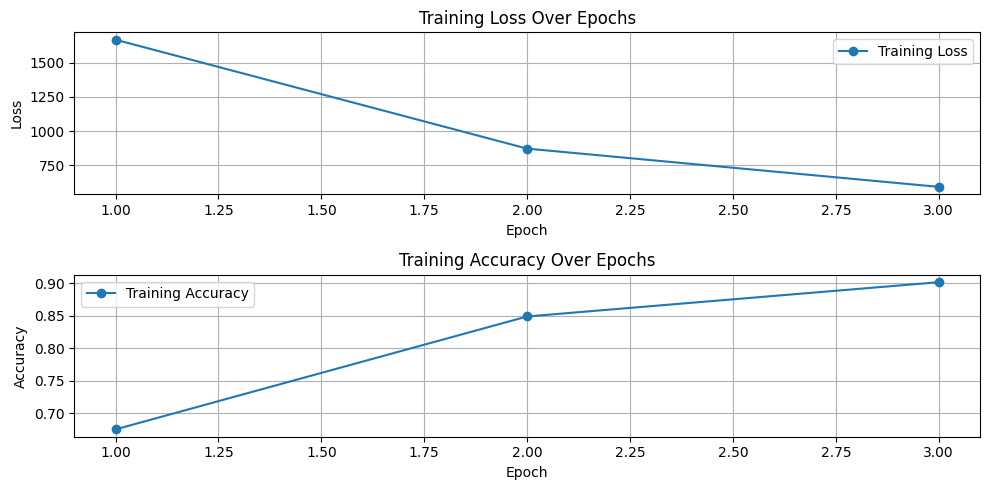

In [31]:
# Используем AutoModelForSequenceClassification, поскольку она уже включает в себя голову классификации (полносвязный слой и softmax-активация)

from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt

# Загрузим предобученную модель (часть весов, связанных с классификацией на 5 классов будут переобучены)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)


# Определим optimizer и функцию потерь
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # learning rate оптимален, L2 регуляризация не приводит к видимому улучшению
criterion = nn.CrossEntropyLoss()

# Обучение
num_epochs = 3 # увеличение кол-ва эпох не приводит к улучшению результата
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Расчет точности на текущем батче
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

    # Рассчитываем точность и функцию потерь только если есть данные в батче
    if len(train_loader) > 0:
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {total_loss:.3f}')

        # Сохраняем значение функции потерь и точности для текущей эпохи
        train_losses.append(total_loss)
        train_accuracy = correct_predictions / total_predictions
        train_accuracies.append(train_accuracy)

        print(f'\tTrain Accuracy: {train_accuracy:.4f}')

# Визуализация функции потерь и точности
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [32]:
model.eval()
valid_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        valid_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {accuracy:.4f}')


Validation Loss: 209.3965, Validation Accuracy: 0.8609


## Выгрузка test результата bert

In [ ]:
# Загрузка данных из test.csv
test_df = pd.read_csv('data/test.csv')
test_df.head(3)

# Чистим текст от мусора
test_df.Text = test_df.Text.apply(lambda text: clean_text(text))

# Токенизация и подготовка данных
test_encodings = tokenizer(list(test_df['Text']), truncation=True, padding=True, return_tensors='pt')
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])

# DataLoader для тестовых данных
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Массив для сохранения предсказаний
all_predictions = []

# Переключаем модель в режим оценки (evaluation)
model.eval()

# Проходим по данным тестового набора
for batch in test_loader:
    input_ids, attention_mask = batch
    input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

    # Вычисляем предсказания
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Получаем вероятности для классов
    logits = outputs.logits
    # Применяем softmax, чтобы получить вероятности
    probabilities = nn.functional.softmax(logits, dim=1)
    # Получаем предсказанный класс (максимальную вероятность)
    predictions = torch.argmax(probabilities, dim=1)
    all_predictions.extend(predictions.cpu().numpy())

# Добавляем предсказания в DataFrame
test_df['Sentiment_encoded'] = all_predictions

# Обратно перекодируем Sentiment
test_df['Sentiment'] = le.inverse_transform(test_df['Sentiment_encoded'])

# Выгружаем данные в submission.csv
submission_df = test_df[['id', 'Sentiment']]
submission_df.to_csv('data/sample_submission_transformer.csv', index=False)